# Conformal matrix completion with weighted sampling

This notebook investigates conformal matrix completion with weighted sampling. The goal is to:
1. Define a reasonable way to construct weight functions to sample the observation sets. Show the standard conformal prediction set fails to achieve the marginal covetage under the weighted sampling model. 
2. Show by experiments that weighted conformal prediction intervals are robust to covariate shift in the sense that they provide valid marginal coverage for the biased sampling scheme. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from tqdm import tqdm

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *  
from wsc import *

(CVXPY) May 11 12:32:25 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [4]:
import math
from tqdm import tqdm
from time import time
import pdb

In [5]:
# Define the latent weights based on the factor matrices
class SamplingBias():
    def __init__(self, m, n, standardize=True):
        self.m = m
        self.n = n
        self.shape = (self.m, self.n)
        self.std = standardize
        
    def latent_weights(self, U, V, v, a, b, scale=0.5):
        r = int(len(v)/2)
        x = np.tile(np.dot(U, v[:r]), (len(U),1)).T + np.tile(np.dot(V, v[r:]), (len(U),1))
        w = np.zeros_like(x)
        w[np.where((x <= b) & (x >= a))] = 1
        w[np.where(x > b)] = scipy.stats.norm.pdf(x[np.where(x > b)], loc=b, scale=scale)/scipy.stats.norm.pdf(b, loc=b, scale=scale)
        w[np.where(x < a)] = scipy.stats.norm.pdf(x[np.where(x < a)], loc=a, scale=scale)/scipy.stats.norm.pdf(a, loc=a, scale=scale)
        return w/np.sum(w) if self.std else w

    def unif_weights(self):
        w = np.ones(self.shape)
        return w/np.sum(w) if self.std else w

    def inc_weights(self, scale=1):
        w = np.arange(1, self.m*self.n+1)**scale/(self.m*self.n)
        w = w.reshape(self.shape)
        return w/np.sum(w) if self.std else w

## Weighted model 1
For the model outline and method details, refer to Section 5.3 in the CMC Overleaf draft.
In this setting, we consider $w_1(I_i) = \frac{i}{N}$ where $N$ is the total number of entries in the matrix, and $w_2(I_i)=\frac{1}{n_{\text{test}}}$. Roughly speaking, observations are sampled with a probability proportional to the index value and test points are uniformly sampled from the missing entries.

In [6]:
# Define experiment parameters
m, n, r = 200,200,10
prop_obs = 0.5
alpha = 0.1
random_state = 2

In [7]:
# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.3
biasmodel = SamplingBias(m,n)
w = biasmodel.inc_weights(scale=scale)

Sampling with weight from the noiseless random factorization model... 

Dark spots indicating the missing entries.


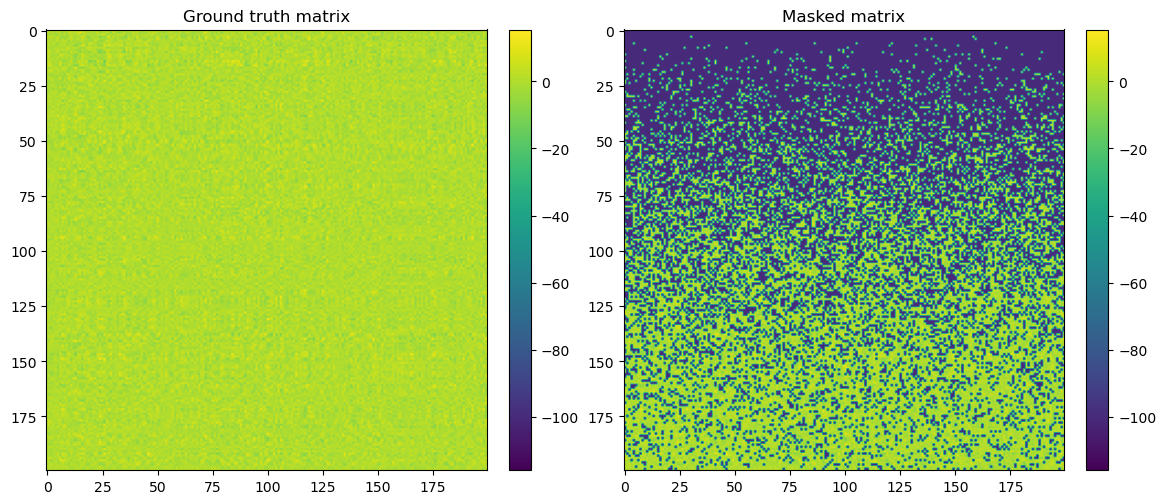

Observation size: 20000, training size: 16000, calib size: 4000


In [8]:
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

print('Sampling with weight from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
sampler = RandomSampling(m, n)
obs = sampler.sample_observed(prop_obs, w=w, random_state=random_state)
test = np.ones_like(obs) - obs
train, calib = sampler.sample_train_calib(obs, calib_size=0.2*np.sum(obs), 
                                            random_state = random_state)
assert np.sum(train+calib==obs) == m*n,'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}"
      .format(np.sum(obs), np.sum(train), np.sum(calib)))

In [9]:
print("Weighted sampling\n"+"-"*25)
print('Solving matrix completion with PMF...')
Mhat, U, VT = pmf_solve(M, train, k=r, random_state=random_state, verbose=True)
test_mse = evaluate_mse(M, Mhat, test)
train_mse = evaluate_mse(M, Mhat, train)
calib_mse = evaluate_mse(M, Mhat, calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Weighted sampling
-------------------------
Solving matrix completion with PMF...
Iteration: 1; Mean diff: 0.0034
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Stopping criteria met, training terminated.
train MSE: 8.42346047185266e-07, calib MSE: 0.039579659501223774, test MSE: 0.9428914494745397


Weighted sampling
-------------------------


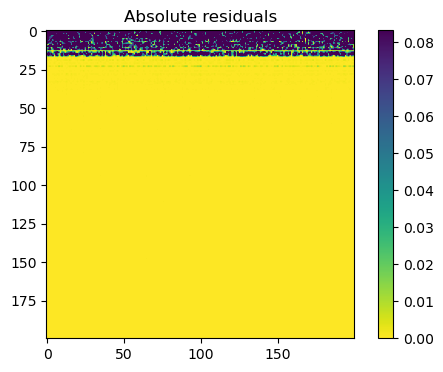

In [10]:
print("Weighted sampling\n"+"-"*25)
error_heatmap(M, Mhat, test)
#residual_hist(M, Mhat, train, calib, test)

## Experiments

We conduct some experiments with the toy models and compute the conformal prediction intervals for test points with the simplest scores based on estimation residuals for both exchangeble settings and covariate shift settings.

### Experiment 1: Fixing M, resample train, test, calib sets

In [11]:
def run_single_experiment(M, Mhat, Uhat, Vhat, w_obs, w_test, train_mask, test_mask, calib_mask, 
                          alpha, r= None, verbose=True, random_state=0):
    # Sanity check
    assert all(((train_mask + test_mask + calib_mask) <= 1).flatten()),\
           'Found error in sampling process, make sure splitted sets are disjoint'
        
    M_flat = M.flatten(order='C')
    cpi = Conformal_PI(M, Mhat, train_mask, calib_mask)
    test_idxs = np.where(test_mask.flatten(order='C')== 1)[0]
    
    spi = cpi.standard_PI(test_mask, alpha)
    wpi = cpi.weighted_PI(test_mask, w_obs, w_test, alpha, allow_inf=True)
    non_inf= [i for i in range(len(wpi)) if wpi[i]!=[-np.inf, np.inf]]
        
    calib_mse = evaluate_mse(M, Mhat, calib_mask)
    train_mse = evaluate_mse(M, Mhat, train_mask)
    test_mse = evaluate_mse(M, Mhat, test_mask)
    
    results = evaluate_PI(spi, M_flat[test_idxs], label="standard")
    results = pd.concat([results, evaluate_PI(wpi, M_flat[test_idxs], label="inf")], axis=1)
    results = pd.concat([results, evaluate_PI(np.array(wpi)[non_inf], M_flat[test_idxs[non_inf]], label="noinf")], axis=1)
    results['inf_prop'] = [1-len(non_inf)/len(test_idxs)]
    results['Calib_MSE'] = [calib_mse]
    results['Train_MSE'] = [train_mse]
    results['Test_MSE'] = [test_mse]
    results['Alpha'] = [alpha]
    results['Seed'] = [random_state]
    results['Calib_size'] = [np.sum(calib_mask)]
    results['Train_size'] = [np.sum(train_mask)]
    results['Test_size'] = [len(test_idxs)]
    
    # If the true rank or an estimation is given, approximate the minimal sufficient sample size 
    # for exact coverage.
    if r:
        results['Theory_size'] = [theoretical_bound(M.shape[0], M.shape[1], r, C=1)]
    return results

In [12]:
# Define experiment parameters
m, n, r = 300,300,10
prop_obs = 0.2
alpha = 0.1
repetition = 50
test_size = np.min([5000, m*n*(1-prop_obs)])

In [13]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.3
biasmodel = SamplingBias(m,n)
w_obs = biasmodel.inc_weights(scale=scale)
w_test = biasmodel.unif_weights()

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



In [14]:
results_w = pd.DataFrame({})

#[NOTE] change the solver's max iteration if the training process takes too long
for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
    random_state = i
    
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs = sampler.sample_observed(prop_obs, w=w_obs, random_state=random_state)
    test = np.ones_like(obs) - obs
    _, sub_test = sampler.sample_train_calib(obs, calib_size=int(), 
                                                random_state = random_state)
    
    n_calib = np.min([4000, int(0.2*np.sum(obs))])
    train, calib = sampler.sample_train_calib(obs, calib_size=n_calib, 
                                                random_state = random_state)
    
    print("Running matrix completion algorithm on the training set...")
    Mhat, Uhat, Vhat = pmf_solve(M, train, k=r, verbose=True, random_state=random_state)
    print("Done training!")
        
    print("Training size:{}, calib size: {}, test size: {}".format(np.sum(train), np.sum(calib), np.sum(test)))
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    res = run_single_experiment(M, Mhat, Uhat, Vhat, w_obs, w_test, train, test, calib, alpha, 
                          r= r, verbose=True, random_state=i)
    
    results_w = pd.concat([results_w, res])

Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0197
Iteration: 2; Mean diff: 0.0122
Iteration: 3; Mean diff: 0.0089
Iteration: 4; Mean diff: 0.0073
Iteration: 5; Mean diff: 0.0063
Iteration: 6; Mean diff: 0.0044
Iteration: 7; Mean diff: 0.0021
Iteration: 8; Mean diff: 0.0013
Iteration: 9; Mean diff: 0.0014
Iteration: 10; Mean diff: 0.0014
Iteration: 11; Mean diff: 0.0016
Iteration: 12; Mean diff: 0.0032
Iteration: 13; Mean diff: 0.0006
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0001
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 632859.70it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:   2%|█▎                                                                 | 1/50 [02:06<1:43:15, 126.45s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0194
Iteration: 2; Mean diff: 0.0133
Iteration: 3; Mean diff: 0.0080
Iteration: 4; Mean diff: 0.0077
Iteration: 5; Mean diff: 0.0094
Iteration: 6; Mean diff: 0.0064
Iteration: 7; Mean diff: 0.0028
Iteration: 8; Mean diff: 0.0012
Iteration: 9; Mean diff: 0.0012
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 541901.69it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:   4%|██▋                                                                | 2/50 [04:10<1:39:51, 124.83s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0033
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1535789.09it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:   6%|████                                                               | 3/50 [05:49<1:28:49, 113.40s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0171
Iteration: 2; Mean diff: 0.0101
Iteration: 3; Mean diff: 0.0081
Iteration: 4; Mean diff: 0.0079
Iteration: 5; Mean diff: 0.0047
Iteration: 6; Mean diff: 0.0050
Iteration: 7; Mean diff: 0.0045
Iteration: 8; Mean diff: 0.0019
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0003
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0003
Iteration: 20; Mean diff: 0.0003
Iteration: 21; Mean diff: 0.0004
Iteration: 22; Mean diff: 0.0004
Iteration: 23; Mean diff: 0.0004
Iteration: 24; Mean diff: 0.0005
Iteration: 25; Mean diff: 0.0008
Iteration: 26; Mean diff: 0.0015
Iteration: 27; Mean diff: 0.0032
Iteration: 28; Mean diff: 0.0006
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 574661.69it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:   8%|█████▎                                                             | 4/50 [07:44<1:27:13, 113.77s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0191
Iteration: 2; Mean diff: 0.0133
Iteration: 3; Mean diff: 0.0092
Iteration: 4; Mean diff: 0.0076
Iteration: 5; Mean diff: 0.0080
Iteration: 6; Mean diff: 0.0043
Iteration: 7; Mean diff: 0.0016
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 803733.19it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  10%|██████▋                                                            | 5/50 [09:30<1:23:21, 111.14s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0216
Iteration: 2; Mean diff: 0.0119
Iteration: 3; Mean diff: 0.0103
Iteration: 4; Mean diff: 0.0081
Iteration: 5; Mean diff: 0.0063
Iteration: 6; Mean diff: 0.0044
Iteration: 7; Mean diff: 0.0049
Iteration: 8; Mean diff: 0.0031
Iteration: 9; Mean diff: 0.0030
Iteration: 10; Mean diff: 0.0011
Iteration: 11; Mean diff: 0.0006
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0001
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 657838.31it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  12%|████████                                                           | 6/50 [11:19<1:20:51, 110.27s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0191
Iteration: 2; Mean diff: 0.0129
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0052
Iteration: 5; Mean diff: 0.0043
Iteration: 6; Mean diff: 0.0035
Iteration: 7; Mean diff: 0.0018
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1142611.33it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  14%|█████████▍                                                         | 7/50 [13:11<1:19:33, 111.01s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0202
Iteration: 2; Mean diff: 0.0125
Iteration: 3; Mean diff: 0.0092
Iteration: 4; Mean diff: 0.0066
Iteration: 5; Mean diff: 0.0056
Iteration: 6; Mean diff: 0.0056
Iteration: 7; Mean diff: 0.0038
Iteration: 8; Mean diff: 0.0021
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0005
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0003
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0004
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0005
Iteration: 21; Mean diff: 0.0007
Iteration: 22; Mean diff: 0.0015
Iteration: 23; Mean diff: 0.0054
Iteration: 24; Mean diff: 0.0012
Iteration: 25; Mean diff: 0.0007
Iteration: 26; Mean diff: 0.0003
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 575994.51it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  16%|██████████▋                                                        | 8/50 [15:31<1:24:04, 120.10s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0186
Iteration: 2; Mean diff: 0.0129
Iteration: 3; Mean diff: 0.0082
Iteration: 4; Mean diff: 0.0062
Iteration: 5; Mean diff: 0.0043
Iteration: 6; Mean diff: 0.0051
Iteration: 7; Mean diff: 0.0034
Iteration: 8; Mean diff: 0.0018
Iteration: 9; Mean diff: 0.0013
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 657660.67it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  18%|████████████                                                       | 9/50 [17:46<1:25:20, 124.88s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0175
Iteration: 2; Mean diff: 0.0109
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0066
Iteration: 5; Mean diff: 0.0050
Iteration: 6; Mean diff: 0.0036
Iteration: 7; Mean diff: 0.0031
Iteration: 8; Mean diff: 0.0027
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 657451.63it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  20%|█████████████▏                                                    | 10/50 [20:02<1:25:34, 128.36s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0210
Iteration: 2; Mean diff: 0.0138
Iteration: 3; Mean diff: 0.0084
Iteration: 4; Mean diff: 0.0071
Iteration: 5; Mean diff: 0.0055
Iteration: 6; Mean diff: 0.0042
Iteration: 7; Mean diff: 0.0029
Iteration: 8; Mean diff: 0.0028
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 767970.70it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  22%|██████████████▌                                                   | 11/50 [21:47<1:18:46, 121.19s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0199
Iteration: 2; Mean diff: 0.0126
Iteration: 3; Mean diff: 0.0099
Iteration: 4; Mean diff: 0.0065
Iteration: 5; Mean diff: 0.0055
Iteration: 6; Mean diff: 0.0029
Iteration: 7; Mean diff: 0.0025
Iteration: 8; Mean diff: 0.0068
Iteration: 9; Mean diff: 0.0014
Iteration: 10; Mean diff: 0.0008
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 767884.78it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  24%|███████████████▊                                                  | 12/50 [23:28<1:12:45, 114.87s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0201
Iteration: 2; Mean diff: 0.0127
Iteration: 3; Mean diff: 0.0092
Iteration: 4; Mean diff: 0.0067
Iteration: 5; Mean diff: 0.0058
Iteration: 6; Mean diff: 0.0064
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0008
Iteration: 10; Mean diff: 0.0012
Iteration: 11; Mean diff: 0.0034
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 658245.54it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  26%|█████████████████▏                                                | 13/50 [25:27<1:11:37, 116.16s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0183
Iteration: 2; Mean diff: 0.0111
Iteration: 3; Mean diff: 0.0072
Iteration: 4; Mean diff: 0.0055
Iteration: 5; Mean diff: 0.0048
Iteration: 6; Mean diff: 0.0047
Iteration: 7; Mean diff: 0.0054
Iteration: 8; Mean diff: 0.0030
Iteration: 9; Mean diff: 0.0026
Iteration: 10; Mean diff: 0.0013
Iteration: 11; Mean diff: 0.0007
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0002
Iteration: 16; Mean diff: 0.0002
Iteration: 17; Mean diff: 0.0002
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1150525.33it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  28%|██████████████████▍                                               | 14/50 [27:52<1:14:55, 124.87s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0193
Iteration: 2; Mean diff: 0.0120
Iteration: 3; Mean diff: 0.0080
Iteration: 4; Mean diff: 0.0060
Iteration: 5; Mean diff: 0.0055
Iteration: 6; Mean diff: 0.0037
Iteration: 7; Mean diff: 0.0034
Iteration: 8; Mean diff: 0.0017
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 658107.83it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  30%|███████████████████▊                                              | 15/50 [29:42<1:10:08, 120.26s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0197
Iteration: 2; Mean diff: 0.0135
Iteration: 3; Mean diff: 0.0087
Iteration: 4; Mean diff: 0.0072
Iteration: 5; Mean diff: 0.0064
Iteration: 6; Mean diff: 0.0067
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0011
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1150074.03it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  32%|█████████████████████                                             | 16/50 [31:41<1:07:59, 119.98s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0197
Iteration: 2; Mean diff: 0.0133
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0055
Iteration: 5; Mean diff: 0.0054
Iteration: 6; Mean diff: 0.0044
Iteration: 7; Mean diff: 0.0063
Iteration: 8; Mean diff: 0.0038
Iteration: 9; Mean diff: 0.0008
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0003
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0006
Iteration: 15; Mean diff: 0.0025
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 657705.07it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  34%|██████████████████████▍                                           | 17/50 [33:29<1:03:58, 116.31s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0182
Iteration: 2; Mean diff: 0.0118
Iteration: 3; Mean diff: 0.0084
Iteration: 4; Mean diff: 0.0073
Iteration: 5; Mean diff: 0.0077
Iteration: 6; Mean diff: 0.0038
Iteration: 7; Mean diff: 0.0030
Iteration: 8; Mean diff: 0.0026
Iteration: 9; Mean diff: 0.0041
Iteration: 10; Mean diff: 0.0008
Iteration: 11; Mean diff: 0.0005
Iteration: 12; Mean diff: 0.0003
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0002
Iteration: 16; Mean diff: 0.0002
Iteration: 17; Mean diff: 0.0002
Iteration: 18; Mean diff: 0.0001
Iteration: 19; Mean diff: 0.0001
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1021623.58it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  36%|███████████████████████▊                                          | 18/50 [36:24<1:11:32, 134.15s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0252
Iteration: 2; Mean diff: 0.0177
Iteration: 3; Mean diff: 0.0102
Iteration: 4; Mean diff: 0.0070
Iteration: 5; Mean diff: 0.0051
Iteration: 6; Mean diff: 0.0043
Iteration: 7; Mean diff: 0.0037
Iteration: 8; Mean diff: 0.0032
Iteration: 9; Mean diff: 0.0018
Iteration: 10; Mean diff: 0.0033
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 500145.56it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  38%|█████████████████████████                                         | 19/50 [38:19<1:06:14, 128.21s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0178
Iteration: 2; Mean diff: 0.0111
Iteration: 3; Mean diff: 0.0089
Iteration: 4; Mean diff: 0.0057
Iteration: 5; Mean diff: 0.0053
Iteration: 6; Mean diff: 0.0035
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0008
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0002
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0004
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0006
Iteration: 21; Mean diff: 0.0010
Iteration: 22; Mean diff: 0.0030
Iteration: 23; Mean diff: 0.0008
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1357129.83it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  40%|██████████████████████████▍                                       | 20/50 [40:29<1:04:28, 128.93s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0178
Iteration: 2; Mean diff: 0.0120
Iteration: 3; Mean diff: 0.0086
Iteration: 4; Mean diff: 0.0075
Iteration: 5; Mean diff: 0.0053
Iteration: 6; Mean diff: 0.0053
Iteration: 7; Mean diff: 0.0016
Iteration: 8; Mean diff: 0.0013
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0006
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0004
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0003
Iteration: 26; Mean diff: 0.0003
Iteration: 27; Mean diff: 0.0005
Iteration: 28; Mean diff: 0.0010
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 489929.17it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  42%|███████████████████████████▋                                      | 21/50 [42:40<1:02:37, 129.55s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0243
Iteration: 2; Mean diff: 0.0178
Iteration: 3; Mean diff: 0.0103
Iteration: 4; Mean diff: 0.0086
Iteration: 5; Mean diff: 0.0054
Iteration: 6; Mean diff: 0.0041
Iteration: 7; Mean diff: 0.0034
Iteration: 8; Mean diff: 0.0029
Iteration: 9; Mean diff: 0.0019
Iteration: 10; Mean diff: 0.0023
Iteration: 11; Mean diff: 0.0023
Iteration: 12; Mean diff: 0.0018
Iteration: 13; Mean diff: 0.0022
Iteration: 14; Mean diff: 0.0043
Iteration: 15; Mean diff: 0.0015
Iteration: 16; Mean diff: 0.0013
Iteration: 17; Mean diff: 0.0011
Iteration: 18; Mean diff: 0.0010
Iteration: 19; Mean diff: 0.0010
Iteration: 20; Mean diff: 0.0009
Iteration: 21; Mean diff: 0.0008
Iteration: 22; Mean diff: 0.0008
Iteration: 23; Mean diff: 0.0007
Iteration: 24; Mean diff: 0.0007
Iteration: 25; Mean diff: 0.0006
Iteration: 26; Mean diff: 0.0006
Iteration: 27; Mean diff: 0.0006
Iteration: 28; Mean diff: 0.0005
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1028390.27it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  44%|█████████████████████████████                                     | 22/50 [45:26<1:05:34, 140.52s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0239
Iteration: 2; Mean diff: 0.0149
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0090
Iteration: 5; Mean diff: 0.0054
Iteration: 6; Mean diff: 0.0044
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0016
Iteration: 9; Mean diff: 0.0014
Iteration: 10; Mean diff: 0.0027
Iteration: 11; Mean diff: 0.0024
Iteration: 12; Mean diff: 0.0007
Iteration: 13; Mean diff: 0.0011
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0002
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 622639.02it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  46%|██████████████████████████████▎                                   | 23/50 [48:02<1:05:19, 145.15s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0175
Iteration: 2; Mean diff: 0.0110
Iteration: 3; Mean diff: 0.0082
Iteration: 4; Mean diff: 0.0063
Iteration: 5; Mean diff: 0.0048
Iteration: 6; Mean diff: 0.0049
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0011
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 947529.24it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  48%|████████████████████████████████▋                                   | 24/50 [49:59<59:14, 136.70s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0194
Iteration: 2; Mean diff: 0.0119
Iteration: 3; Mean diff: 0.0078
Iteration: 4; Mean diff: 0.0075
Iteration: 5; Mean diff: 0.0055
Iteration: 6; Mean diff: 0.0040
Iteration: 7; Mean diff: 0.0024
Iteration: 8; Mean diff: 0.0033
Iteration: 9; Mean diff: 0.0008
Iteration: 10; Mean diff: 0.0007
Iteration: 11; Mean diff: 0.0015
Iteration: 12; Mean diff: 0.0038
Iteration: 13; Mean diff: 0.0008
Iteration: 14; Mean diff: 0.0005
Iteration: 15; Mean diff: 0.0002
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 571242.98it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  50%|██████████████████████████████████                                  | 25/50 [51:46<53:08, 127.56s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0185
Iteration: 2; Mean diff: 0.0115
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0067
Iteration: 5; Mean diff: 0.0050
Iteration: 6; Mean diff: 0.0033
Iteration: 7; Mean diff: 0.0021
Iteration: 8; Mean diff: 0.0009
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1141993.44it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  52%|███████████████████████████████████▎                                | 26/50 [53:47<50:18, 125.77s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0226
Iteration: 2; Mean diff: 0.0160
Iteration: 3; Mean diff: 0.0095
Iteration: 4; Mean diff: 0.0084
Iteration: 5; Mean diff: 0.0059
Iteration: 6; Mean diff: 0.0047
Iteration: 7; Mean diff: 0.0047
Iteration: 8; Mean diff: 0.0021
Iteration: 9; Mean diff: 0.0019
Iteration: 10; Mean diff: 0.0017
Iteration: 11; Mean diff: 0.0011
Iteration: 12; Mean diff: 0.0008
Iteration: 13; Mean diff: 0.0006
Iteration: 14; Mean diff: 0.0005
Iteration: 15; Mean diff: 0.0004
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0002
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 575444.63it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  54%|████████████████████████████████████▋                               | 27/50 [56:28<52:14, 136.27s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0207
Iteration: 2; Mean diff: 0.0140
Iteration: 3; Mean diff: 0.0098
Iteration: 4; Mean diff: 0.0076
Iteration: 5; Mean diff: 0.0046
Iteration: 6; Mean diff: 0.0050
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0012
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0004
Iteration: 17; Mean diff: 0.0008
Iteration: 18; Mean diff: 0.0026
Iteration: 19; Mean diff: 0.0005
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 616487.07it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  56%|██████████████████████████████████████                              | 28/50 [58:59<51:37, 140.80s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0174
Iteration: 2; Mean diff: 0.0114
Iteration: 3; Mean diff: 0.0087
Iteration: 4; Mean diff: 0.0053
Iteration: 5; Mean diff: 0.0047
Iteration: 6; Mean diff: 0.0030
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 524381.77it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  58%|██████████████████████████████████████▎                           | 29/50 [1:00:52<46:21, 132.45s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0197
Iteration: 2; Mean diff: 0.0128
Iteration: 3; Mean diff: 0.0103
Iteration: 4; Mean diff: 0.0070
Iteration: 5; Mean diff: 0.0055
Iteration: 6; Mean diff: 0.0048
Iteration: 7; Mean diff: 0.0027
Iteration: 8; Mean diff: 0.0014
Iteration: 9; Mean diff: 0.0008
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0001
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0001
Iteration: 18; Mean diff: 0.0001
Iteration: 19; Mean diff: 0.0001
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 575931.89it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  60%|███████████████████████████████████████▌                          | 30/50 [1:03:31<46:43, 140.19s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0220
Iteration: 2; Mean diff: 0.0157
Iteration: 3; Mean diff: 0.0084
Iteration: 4; Mean diff: 0.0059
Iteration: 5; Mean diff: 0.0040
Iteration: 6; Mean diff: 0.0052
Iteration: 7; Mean diff: 0.0028
Iteration: 8; Mean diff: 0.0028
Iteration: 9; Mean diff: 0.0032
Iteration: 10; Mean diff: 0.0010
Iteration: 11; Mean diff: 0.0005
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0004
Iteration: 14; Mean diff: 0.0004
Iteration: 15; Mean diff: 0.0004
Iteration: 16; Mean diff: 0.0004
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0003
Iteration: 20; Mean diff: 0.0003
Iteration: 21; Mean diff: 0.0003
Iteration: 22; Mean diff: 0.0003
Iteration: 23; Mean diff: 0.0003
Iteration: 24; Mean diff: 0.0003
Iteration: 25; Mean diff: 0.0003
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0003
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 656120.35it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  62%|████████████████████████████████████████▉                         | 31/50 [1:06:09<46:05, 145.58s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0202
Iteration: 2; Mean diff: 0.0146
Iteration: 3; Mean diff: 0.0073
Iteration: 4; Mean diff: 0.0058
Iteration: 5; Mean diff: 0.0054
Iteration: 6; Mean diff: 0.0053
Iteration: 7; Mean diff: 0.0020
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0006
Iteration: 14; Mean diff: 0.0012
Iteration: 15; Mean diff: 0.0051
Iteration: 16; Mean diff: 0.0011
Iteration: 17; Mean diff: 0.0006
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0001
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 600116.23it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  64%|██████████████████████████████████████████▏                       | 32/50 [1:08:05<41:02, 136.78s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0194
Iteration: 2; Mean diff: 0.0126
Iteration: 3; Mean diff: 0.0097
Iteration: 4; Mean diff: 0.0062
Iteration: 5; Mean diff: 0.0038
Iteration: 6; Mean diff: 0.0044
Iteration: 7; Mean diff: 0.0030
Iteration: 8; Mean diff: 0.0008
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1239207.41it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  66%|███████████████████████████████████████████▌                      | 33/50 [1:09:55<36:29, 128.78s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0192
Iteration: 2; Mean diff: 0.0114
Iteration: 3; Mean diff: 0.0094
Iteration: 4; Mean diff: 0.0072
Iteration: 5; Mean diff: 0.0052
Iteration: 6; Mean diff: 0.0048
Iteration: 7; Mean diff: 0.0030
Iteration: 8; Mean diff: 0.0035
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 643006.41it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  68%|████████████████████████████████████████████▉                     | 34/50 [1:11:43<32:38, 122.43s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0177
Iteration: 2; Mean diff: 0.0112
Iteration: 3; Mean diff: 0.0096
Iteration: 4; Mean diff: 0.0075
Iteration: 5; Mean diff: 0.0049
Iteration: 6; Mean diff: 0.0029
Iteration: 7; Mean diff: 0.0017
Iteration: 8; Mean diff: 0.0014
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1182298.94it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  70%|██████████████████████████████████████████████▏                   | 35/50 [1:13:46<30:38, 122.56s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0173
Iteration: 2; Mean diff: 0.0101
Iteration: 3; Mean diff: 0.0091
Iteration: 4; Mean diff: 0.0077
Iteration: 5; Mean diff: 0.0052
Iteration: 6; Mean diff: 0.0042
Iteration: 7; Mean diff: 0.0016
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 612279.84it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  72%|███████████████████████████████████████████████▌                  | 36/50 [1:15:37<27:47, 119.14s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0180
Iteration: 2; Mean diff: 0.0113
Iteration: 3; Mean diff: 0.0075
Iteration: 4; Mean diff: 0.0058
Iteration: 5; Mean diff: 0.0059
Iteration: 6; Mean diff: 0.0050
Iteration: 7; Mean diff: 0.0045
Iteration: 8; Mean diff: 0.0033
Iteration: 9; Mean diff: 0.0027
Iteration: 10; Mean diff: 0.0006
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1179155.15it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  74%|████████████████████████████████████████████████▊                 | 37/50 [1:17:48<26:34, 122.69s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0231
Iteration: 2; Mean diff: 0.0143
Iteration: 3; Mean diff: 0.0120
Iteration: 4; Mean diff: 0.0069
Iteration: 5; Mean diff: 0.0078
Iteration: 6; Mean diff: 0.0047
Iteration: 7; Mean diff: 0.0036
Iteration: 8; Mean diff: 0.0009
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 657967.31it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  76%|██████████████████████████████████████████████████▏               | 38/50 [1:19:36<23:39, 118.28s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0179
Iteration: 2; Mean diff: 0.0112
Iteration: 3; Mean diff: 0.0089
Iteration: 4; Mean diff: 0.0067
Iteration: 5; Mean diff: 0.0070
Iteration: 6; Mean diff: 0.0053
Iteration: 7; Mean diff: 0.0044
Iteration: 8; Mean diff: 0.0019
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0007
Iteration: 11; Mean diff: 0.0005
Iteration: 12; Mean diff: 0.0005
Iteration: 13; Mean diff: 0.0004
Iteration: 14; Mean diff: 0.0005
Iteration: 15; Mean diff: 0.0008
Iteration: 16; Mean diff: 0.0032
Iteration: 17; Mean diff: 0.0006
Iteration: 18; Mean diff: 0.0004
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1358766.31it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  78%|███████████████████████████████████████████████████▍              | 39/50 [1:21:24<21:08, 115.35s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0225
Iteration: 2; Mean diff: 0.0161
Iteration: 3; Mean diff: 0.0089
Iteration: 4; Mean diff: 0.0078
Iteration: 5; Mean diff: 0.0056
Iteration: 6; Mean diff: 0.0048
Iteration: 7; Mean diff: 0.0042
Iteration: 8; Mean diff: 0.0020
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 616031.82it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  80%|████████████████████████████████████████████████████▊             | 40/50 [1:23:50<20:45, 124.53s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0191
Iteration: 2; Mean diff: 0.0129
Iteration: 3; Mean diff: 0.0094
Iteration: 4; Mean diff: 0.0059
Iteration: 5; Mean diff: 0.0047
Iteration: 6; Mean diff: 0.0039
Iteration: 7; Mean diff: 0.0034
Iteration: 8; Mean diff: 0.0014
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1239446.45it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  82%|██████████████████████████████████████████████████████            | 41/50 [1:25:59<18:51, 125.76s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0170
Iteration: 2; Mean diff: 0.0107
Iteration: 3; Mean diff: 0.0081
Iteration: 4; Mean diff: 0.0063
Iteration: 5; Mean diff: 0.0036
Iteration: 6; Mean diff: 0.0017
Iteration: 7; Mean diff: 0.0008
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0005
Iteration: 13; Mean diff: 0.0006
Iteration: 14; Mean diff: 0.0010
Iteration: 15; Mean diff: 0.0033
Iteration: 16; Mean diff: 0.0005
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0001
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Stopping criteria met, tra

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 592015.15it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  84%|███████████████████████████████████████████████████████▍          | 42/50 [1:27:48<16:07, 120.94s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0180
Iteration: 2; Mean diff: 0.0120
Iteration: 3; Mean diff: 0.0080
Iteration: 4; Mean diff: 0.0068
Iteration: 5; Mean diff: 0.0053
Iteration: 6; Mean diff: 0.0052
Iteration: 7; Mean diff: 0.0041
Iteration: 8; Mean diff: 0.0012
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!


SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1222309.47it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  86%|████████████████████████████████████████████████████████▊         | 43/50 [1:29:37<13:40, 117.15s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0189
Iteration: 2; Mean diff: 0.0113
Iteration: 3; Mean diff: 0.0086
Iteration: 4; Mean diff: 0.0063
Iteration: 5; Mean diff: 0.0052
Iteration: 6; Mean diff: 0.0042
Iteration: 7; Mean diff: 0.0048
Iteration: 8; Mean diff: 0.0036
Iteration: 9; Mean diff: 0.0018
Iteration: 10; Mean diff: 0.0011
Iteration: 11; Mean diff: 0.0007
Iteration: 12; Mean diff: 0.0005
Iteration: 13; Mean diff: 0.0004
Iteration: 14; Mean diff: 0.0004
Iteration: 15; Mean diff: 0.0004
Iteration: 16; Mean diff: 0.0004
Iteration: 17; Mean diff: 0.0004
Iteration: 18; Mean diff: 0.0004
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0004
Iteration: 21; Mean diff: 0.0004
Iteration: 22; Mean diff: 0.0004
Iteration: 23; Mean diff: 0.0004
Iteration: 24; Mean diff: 0.0004
Iteration: 25; Mean diff: 0.0004
Iteration: 26; Mean diff: 0.0004
Iteration: 27; Mean diff: 0.0004
Iteration: 28; Mean diff: 0.0004
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 631310.47it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  88%|██████████████████████████████████████████████████████████        | 44/50 [1:31:57<12:24, 124.04s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0182
Iteration: 2; Mean diff: 0.0111
Iteration: 3; Mean diff: 0.0098
Iteration: 4; Mean diff: 0.0067
Iteration: 5; Mean diff: 0.0054
Iteration: 6; Mean diff: 0.0046
Iteration: 7; Mean diff: 0.0017
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1050479.99it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  90%|███████████████████████████████████████████████████████████▍      | 45/50 [1:33:49<10:02, 120.54s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0176
Iteration: 2; Mean diff: 0.0105
Iteration: 3; Mean diff: 0.0080
Iteration: 4; Mean diff: 0.0068
Iteration: 5; Mean diff: 0.0068
Iteration: 6; Mean diff: 0.0040
Iteration: 7; Mean diff: 0.0045
Iteration: 8; Mean diff: 0.0046
Iteration: 9; Mean diff: 0.0033
Iteration: 10; Mean diff: 0.0021
Iteration: 11; Mean diff: 0.0017
Iteration: 12; Mean diff: 0.0015
Iteration: 13; Mean diff: 0.0013
Iteration: 14; Mean diff: 0.0012
Iteration: 15; Mean diff: 0.0010
Iteration: 16; Mean diff: 0.0009
Iteration: 17; Mean diff: 0.0008
Iteration: 18; Mean diff: 0.0008
Iteration: 19; Mean diff: 0.0011
Iteration: 20; Mean diff: 0.0024
Iteration: 21; Mean diff: 0.0016
Iteration: 22; Mean diff: 0.0006
Iteration: 23; Mean diff: 0.0005
Iteration: 24; Mean diff: 0.0005
Iteration: 25; Mean diff: 0.0005
Iteration: 26; Mean diff: 0.0004
Iteration: 27; Mean diff: 0.0004
Iteration: 28; Mean diff: 0.0004
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 562415.05it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  92%|████████████████████████████████████████████████████████████▋     | 46/50 [1:36:07<08:23, 125.77s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0227
Iteration: 2; Mean diff: 0.0152
Iteration: 3; Mean diff: 0.0104
Iteration: 4; Mean diff: 0.0077
Iteration: 5; Mean diff: 0.0079
Iteration: 6; Mean diff: 0.0033
Iteration: 7; Mean diff: 0.0019
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1178492.52it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  94%|██████████████████████████████████████████████████████████████    | 47/50 [1:38:01<06:06, 122.25s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0183
Iteration: 2; Mean diff: 0.0120
Iteration: 3; Mean diff: 0.0098
Iteration: 4; Mean diff: 0.0070
Iteration: 5; Mean diff: 0.0040
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0027
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 643388.62it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  96%|███████████████████████████████████████████████████████████████▎  | 48/50 [1:39:53<03:58, 119.23s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0207
Iteration: 2; Mean diff: 0.0136
Iteration: 3; Mean diff: 0.0103
Iteration: 4; Mean diff: 0.0066
Iteration: 5; Mean diff: 0.0051
Iteration: 6; Mean diff: 0.0047
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0014
Iteration: 9; Mean diff: 0.0010
Iteration: 10; Mean diff: 0.0023
Iteration: 11; Mean diff: 0.0007
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 513559.42it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions:  98%|████████████████████████████████████████████████████████████████▋ | 49/50 [1:42:07<02:03, 123.55s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0198
Iteration: 2; Mean diff: 0.0128
Iteration: 3; Mean diff: 0.0093
Iteration: 4; Mean diff: 0.0077
Iteration: 5; Mean diff: 0.0056
Iteration: 6; Mean diff: 0.0053
Iteration: 7; Mean diff: 0.0045
Iteration: 8; Mean diff: 0.0030
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 614880.38it/s]

Computing weighted prediction intervals for 72000 test points...



Repetitions: 100%|██████████████████████████████████████████████████████████████████| 50/50 [1:44:11<00:00, 125.04s/it]


Weighted sampling
-------------------------
Test size is 72000, calibration size is 3600, training size is 14400, theoretical minimum training size is 71214.0


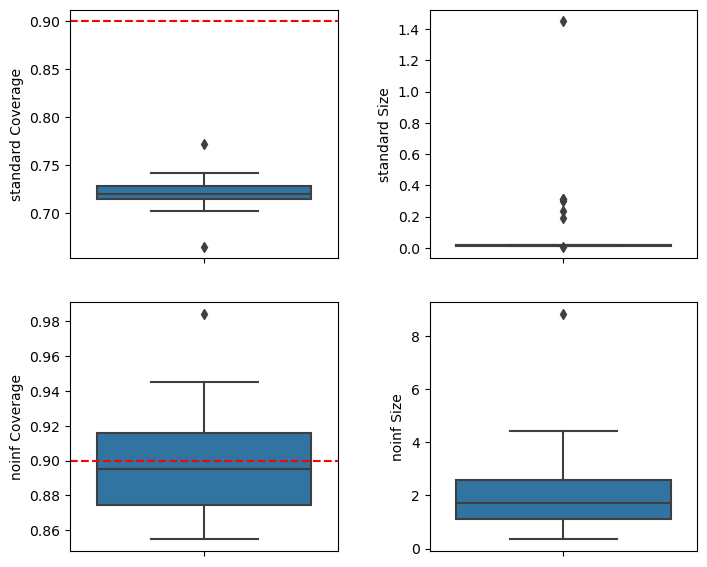

In [15]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results_w['Calib_size'].iloc[0], 
              results_w['Train_size'].iloc[0], results_w['Theory_size'].iloc[0]))

fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout(w_pad=3.5)
sns.boxplot(y="standardCoverage", data=results_w, ax=axs[0,0])
axs[0,0].set(ylabel='standard Coverage')
axs[0,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="standardSize", data=results_w, ax=axs[0,1])
axs[0,1].set(ylabel='standard Size')

sns.boxplot(y="noinfCoverage", data=results_w, ax=axs[1,0])
axs[1,0].set(ylabel='noinf Coverage')
axs[1,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="noinfSize", data=results_w, ax=axs[1,1])
axs[1,1].set(ylabel='noinf Size')
plt.show()

## Experiment 2
In this experiment, we sample the observations uniformly and examine the worst-slab coverage. 

In [16]:
# Define experiment parameters
m, n, r = 300,300,10
prop_obs = 0.2
alpha = 0.1
repetition = 50

print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



In [17]:
results_marginal = pd.DataFrame({})
results_ws = pd.DataFrame({})


for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
    random_state = i
    
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs_mask = sampler.sample_observed(prop_obs, w=w_obs, random_state=random_state)
    missing_mask = np.ones_like(obs_mask)-obs_mask
    
    n_calib = np.min([4000, int(0.2*np.sum(obs_mask))])
    train_mask, calib_mask = sampler.sample_train_calib(obs_mask, calib_size=n_calib, 
                                                random_state = random_state)
    
    print("Running matrix completion algorithm on the training set...")
    Mhat, Uhat, Vhat = pmf_solve(M, train_mask, k=r, verbose=True, random_state=random_state)
    print("Done training!")
        
    print("Training size:{}, calib size: {}, test size: {}".format(np.sum(train), np.sum(calib), np.sum(test)))
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    # define the weights
    biasmodel = SamplingBias(m,n,standardize=True)
    w_obs = biasmodel.unif_weights()

    # Run test marginally on all missing points
    cpi = Conformal_PI(M, Mhat, train_mask, calib_mask)
    spi = cpi.standard_PI(missing_mask, alpha)
    res_marginal = evaluate_PI(spi, M.flatten()[np.where(missing_mask.flatten()==1)], label="marginal")
    results_marginal = pd.concat([results_marginal, res_marginal])
    
    # Run test conditionally on all the worst-slab 
    cov, (v,a,b), ws_mask = wsc_estimate(M, Uhat, Vhat, missing_mask, spi, random_state=random_state)
    wsc_w = biasmodel.latent_weights(Uhat, Vhat, v, a, b, scale=0.2)
    res_ws = run_single_experiment(M, Mhat, Uhat, Vhat, w_obs, wsc_w, train_mask, ws_mask, calib_mask,
                                alpha, r= r, verbose=True, random_state=i)
    
    results_ws = pd.concat([results_ws, res_ws])

Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0178
Iteration: 2; Mean diff: 0.0152
Iteration: 3; Mean diff: 0.0090
Iteration: 4; Mean diff: 0.0062
Iteration: 5; Mean diff: 0.0065
Iteration: 6; Mean diff: 0.0055
Iteration: 7; Mean diff: 0.0019
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 584719.13it/s]


Computing standard marginal prediction intervals for 5400 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5400/5400 [00:00<00:00, 1707057.70it/s]

Computing weighted prediction intervals for 5400 test points...



Repetitions:   2%|█▍                                                                    | 1/50 [00:17<14:34, 17.85s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0029
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0009
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 517416.07it/s]


Computing standard marginal prediction intervals for 5234 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5234/5234 [00:00<00:00, 1308360.88it/s]

Computing weighted prediction intervals for 5234 test points...



Repetitions:   4%|██▊                                                                   | 2/50 [00:36<14:36, 18.27s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0133
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0037
Iteration: 5; Mean diff: 0.0034
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0012
Iteration: 8; Mean diff: 0.0005
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 492930.44it/s]


Computing standard marginal prediction intervals for 5179 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████████| 5179/5179 [00:00<00:00, 866085.90it/s]

Computing weighted prediction intervals for 5179 test points...



Repetitions:   6%|████▏                                                                 | 3/50 [00:54<14:19, 18.29s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0058
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0029
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0028
Iteration: 8; Mean diff: 0.0025
Iteration: 9; Mean diff: 0.0025
Iteration: 10; Mean diff: 0.0023
Iteration: 11; Mean diff: 0.0021
Iteration: 12; Mean diff: 0.0019
Iteration: 13; Mean diff: 0.0017
Iteration: 14; Mean diff: 0.0016
Iteration: 15; Mean diff: 0.0014
Iteration: 16; Mean diff: 0.0012
Iteration: 17; Mean diff: 0.0011
Iteration: 18; Mean diff: 0.0009
Iteration: 19; Mean diff: 0.0008
Iteration: 20; Mean diff: 0.0007
Iteration: 21; Mean diff: 0.0007
Iteration: 22; Mean diff: 0.0006
Iteration: 23; Mean diff: 0.0006
Iteration: 24; Mean diff: 0.0006
Iteration: 25; Mean diff: 0.0005
Iteration: 26; Mean diff: 0.0005
Iteration: 27; Mean diff: 0.0005
Iteration: 28; Mean diff: 0.0005
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1199462.56it/s]


Computing standard marginal prediction intervals for 5282 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5282/5282 [00:00<00:00, 1762615.46it/s]

Computing weighted prediction intervals for 5282 test points...



Repetitions:   8%|█████▌                                                                | 4/50 [02:07<30:37, 39.94s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0038
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0020
Iteration: 9; Mean diff: 0.0024
Iteration: 10; Mean diff: 0.0018
Iteration: 11; Mean diff: 0.0017
Iteration: 12; Mean diff: 0.0015
Iteration: 13; Mean diff: 0.0014
Iteration: 14; Mean diff: 0.0013
Iteration: 15; Mean diff: 0.0012
Iteration: 16; Mean diff: 0.0011
Iteration: 17; Mean diff: 0.0010
Iteration: 18; Mean diff: 0.0009
Iteration: 19; Mean diff: 0.0008
Iteration: 20; Mean diff: 0.0007
Iteration: 21; Mean diff: 0.0006
Iteration: 22; Mean diff: 0.0006
Iteration: 23; Mean diff: 0.0005
Iteration: 24; Mean diff: 0.0005
Iteration: 25; Mean diff: 0.0005
Iteration: 26; Mean diff: 0.0005
Iteration: 27; Mean diff: 0.0004
Iteration: 28; Mean diff: 0.0004
Iteration: 29; Mean diff: 

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1124758.89it/s]


Computing standard marginal prediction intervals for 5353 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5353/5353 [00:00<00:00, 1073441.83it/s]

Computing weighted prediction intervals for 5353 test points...



Repetitions:  10%|███████                                                               | 5/50 [03:23<39:35, 52.79s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0033
Iteration: 5; Mean diff: 0.0028
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0021
Iteration: 9; Mean diff: 0.0018
Iteration: 10; Mean diff: 0.0015
Iteration: 11; Mean diff: 0.0013
Iteration: 12; Mean diff: 0.0012
Iteration: 13; Mean diff: 0.0011
Iteration: 14; Mean diff: 0.0010
Iteration: 15; Mean diff: 0.0009
Iteration: 16; Mean diff: 0.0008
Iteration: 17; Mean diff: 0.0007
Iteration: 18; Mean diff: 0.0006
Iteration: 19; Mean diff: 0.0005
Iteration: 20; Mean diff: 0.0004
Iteration: 21; Mean diff: 0.0004
Iteration: 22; Mean diff: 0.0003
Iteration: 23; Mean diff: 0.0003
Iteration: 24; Mean diff: 0.0003
Iteration: 25; Mean diff: 0.0003
Iteration: 26; Mean diff: 0.0003
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0002
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 596631.66it/s]


Computing standard marginal prediction intervals for 5572 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5572/5572 [00:00<00:00, 1357969.89it/s]

Computing weighted prediction intervals for 5572 test points...



Repetitions:  12%|████████▍                                                             | 6/50 [04:36<43:50, 59.79s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0127
Iteration: 2; Mean diff: 0.0058
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0031
Iteration: 8; Mean diff: 0.0035
Iteration: 9; Mean diff: 0.0038
Iteration: 10; Mean diff: 0.0027
Iteration: 11; Mean diff: 0.0013
Iteration: 12; Mean diff: 0.0006
Iteration: 13; Mean diff: 0.0009
Iteration: 14; Mean diff: 0.0012
Iteration: 15; Mean diff: 0.0014
Iteration: 16; Mean diff: 0.0015
Iteration: 17; Mean diff: 0.0019
Iteration: 18; Mean diff: 0.0026
Iteration: 19; Mean diff: 0.0035
Iteration: 20; Mean diff: 0.0017
Iteration: 21; Mean diff: 0.0005
Iteration: 22; Mean diff: 0.0003
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0003
Iteration: 28; Mean diff: 0.0005
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 498663.95it/s]


Computing standard marginal prediction intervals for 5424 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5424/5424 [00:00<00:00, 1359826.95it/s]

Computing weighted prediction intervals for 5424 test points...



Repetitions:  14%|█████████▊                                                            | 7/50 [04:57<33:40, 47.00s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0038
Iteration: 5; Mean diff: 0.0034
Iteration: 6; Mean diff: 0.0022
Iteration: 7; Mean diff: 0.0010
Iteration: 8; Mean diff: 0.0005
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0001
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 626186.87it/s]


Computing standard marginal prediction intervals for 5574 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5574/5574 [00:00<00:00, 1382803.01it/s]

Computing weighted prediction intervals for 5574 test points...



Repetitions:  16%|███████████▏                                                          | 8/50 [05:15<26:27, 37.80s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0064
Iteration: 3; Mean diff: 0.0046
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0018
Iteration: 7; Mean diff: 0.0008
Iteration: 8; Mean diff: 0.0004
Iteration: 9; Mean diff: 0.0002
Iteration: 10; Mean diff: 0.0001
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 401016.50it/s]


Computing standard marginal prediction intervals for 5487 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5487/5487 [00:00<00:00, 1373486.87it/s]

Computing weighted prediction intervals for 5487 test points...



Repetitions:  18%|████████████▌                                                         | 9/50 [05:32<21:23, 31.30s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0028
Iteration: 7; Mean diff: 0.0017
Iteration: 8; Mean diff: 0.0008
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 596539.73it/s]


Computing standard marginal prediction intervals for 5521 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5521/5521 [00:00<00:00, 1816358.33it/s]

Computing weighted prediction intervals for 5521 test points...



Repetitions:  20%|█████████████▊                                                       | 10/50 [05:49<17:49, 26.75s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0027
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0022
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 575751.82it/s]


Computing standard marginal prediction intervals for 5627 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5627/5627 [00:00<00:00, 1878490.02it/s]

Computing weighted prediction intervals for 5627 test points...



Repetitions:  22%|███████████████▏                                                     | 11/50 [06:07<15:38, 24.08s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0030
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0017
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 632796.04it/s]


Computing standard marginal prediction intervals for 5667 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5667/5667 [00:00<00:00, 1041591.62it/s]

Computing weighted prediction intervals for 5667 test points...



Repetitions:  24%|████████████████▌                                                    | 12/50 [06:26<14:21, 22.68s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0058
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0024
Iteration: 8; Mean diff: 0.0021
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 525098.44it/s]


Computing standard marginal prediction intervals for 5591 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5591/5591 [00:00<00:00, 1398434.83it/s]

Computing weighted prediction intervals for 5591 test points...



Repetitions:  26%|█████████████████▉                                                   | 13/50 [06:45<13:11, 21.40s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0033
Iteration: 5; Mean diff: 0.0027
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0015
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0008
Iteration: 11; Mean diff: 0.0008
Iteration: 12; Mean diff: 0.0010
Iteration: 13; Mean diff: 0.0013
Iteration: 14; Mean diff: 0.0023
Iteration: 15; Mean diff: 0.0018
Iteration: 16; Mean diff: 0.0007
Iteration: 17; Mean diff: 0.0005
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 605037.38it/s]


Computing standard marginal prediction intervals for 5397 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5397/5397 [00:00<00:00, 1746790.55it/s]

Computing weighted prediction intervals for 5397 test points...



Repetitions:  28%|███████████████████▎                                                 | 14/50 [07:09<13:20, 22.24s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0134
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0046
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0014
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 384900.54it/s]


Computing standard marginal prediction intervals for 5414 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5414/5414 [00:00<00:00, 1678217.56it/s]

Computing weighted prediction intervals for 5414 test points...



Repetitions:  30%|████████████████████▋                                                | 15/50 [07:28<12:27, 21.34s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0133
Iteration: 2; Mean diff: 0.0058
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0035
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0029
Iteration: 8; Mean diff: 0.0015
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 510102.54it/s]


Computing standard marginal prediction intervals for 5614 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5614/5614 [00:00<00:00, 1403267.14it/s]

Computing weighted prediction intervals for 5614 test points...



Repetitions:  32%|██████████████████████                                               | 16/50 [07:46<11:33, 20.40s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0021
Iteration: 8; Mean diff: 0.0016
Iteration: 9; Mean diff: 0.0014
Iteration: 10; Mean diff: 0.0016
Iteration: 11; Mean diff: 0.0018
Iteration: 12; Mean diff: 0.0011
Iteration: 13; Mean diff: 0.0014
Iteration: 14; Mean diff: 0.0014
Iteration: 15; Mean diff: 0.0010
Iteration: 16; Mean diff: 0.0006
Iteration: 17; Mean diff: 0.0004
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0003
Iteration: 20; Mean diff: 0.0004
Iteration: 21; Mean diff: 0.0004
Iteration: 22; Mean diff: 0.0004
Iteration: 23; Mean diff: 0.0005
Iteration: 24; Mean diff: 0.0005
Iteration: 25; Mean diff: 0.0006
Iteration: 26; Mean diff: 0.0007
Iteration: 27; Mean diff: 0.0010
Iteration: 28; Mean diff: 0.0018
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 562605.75it/s]


Computing standard marginal prediction intervals for 5370 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5370/5370 [00:00<00:00, 1307979.82it/s]

Computing weighted prediction intervals for 5370 test points...



Repetitions:  34%|███████████████████████▍                                             | 17/50 [08:06<11:10, 20.32s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0026
Iteration: 6; Mean diff: 0.0026
Iteration: 7; Mean diff: 0.0013
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 624253.02it/s]


Computing standard marginal prediction intervals for 5536 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5536/5536 [00:00<00:00, 1382040.77it/s]

Computing weighted prediction intervals for 5536 test points...



Repetitions:  36%|████████████████████████▊                                            | 18/50 [08:21<09:56, 18.63s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0022
Iteration: 7; Mean diff: 0.0020
Iteration: 8; Mean diff: 0.0022
Iteration: 9; Mean diff: 0.0020
Iteration: 10; Mean diff: 0.0011
Iteration: 11; Mean diff: 0.0004
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1330316.77it/s]


Computing standard marginal prediction intervals for 5358 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5358/5358 [00:00<00:00, 1593835.52it/s]

Computing weighted prediction intervals for 5358 test points...



Repetitions:  38%|██████████████████████████▏                                          | 19/50 [08:36<09:07, 17.65s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0029
Iteration: 7; Mean diff: 0.0025
Iteration: 8; Mean diff: 0.0012
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 582584.93it/s]


Computing standard marginal prediction intervals for 5453 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5453/5453 [00:00<00:00, 1758132.04it/s]

Computing weighted prediction intervals for 5453 test points...



Repetitions:  40%|███████████████████████████▌                                         | 20/50 [08:52<08:29, 16.98s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0041
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0025
Iteration: 8; Mean diff: 0.0020
Iteration: 9; Mean diff: 0.0024
Iteration: 10; Mean diff: 0.0020
Iteration: 11; Mean diff: 0.0014
Iteration: 12; Mean diff: 0.0008
Iteration: 13; Mean diff: 0.0004
Iteration: 14; Mean diff: 0.0004
Iteration: 15; Mean diff: 0.0005
Iteration: 16; Mean diff: 0.0005
Iteration: 17; Mean diff: 0.0006
Iteration: 18; Mean diff: 0.0006
Iteration: 19; Mean diff: 0.0006
Iteration: 20; Mean diff: 0.0007
Iteration: 21; Mean diff: 0.0008
Iteration: 22; Mean diff: 0.0010
Iteration: 23; Mean diff: 0.0016
Iteration: 24; Mean diff: 0.0031
Iteration: 25; Mean diff: 0.0018
Iteration: 26; Mean diff: 0.0004
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 394167.03it/s]


Computing standard marginal prediction intervals for 5662 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5662/5662 [00:00<00:00, 1135351.59it/s]

Computing weighted prediction intervals for 5662 test points...



Repetitions:  42%|████████████████████████████▉                                        | 21/50 [09:16<09:17, 19.22s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0034
Iteration: 6; Mean diff: 0.0026
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0011
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 543622.46it/s]


Computing standard marginal prediction intervals for 5545 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5545/5545 [00:00<00:00, 1850084.77it/s]

Computing weighted prediction intervals for 5545 test points...



Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [09:32<08:31, 18.27s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0040
Iteration: 5; Mean diff: 0.0034
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0015
Iteration: 8; Mean diff: 0.0019
Iteration: 9; Mean diff: 0.0018
Iteration: 10; Mean diff: 0.0015
Iteration: 11; Mean diff: 0.0012
Iteration: 12; Mean diff: 0.0010
Iteration: 13; Mean diff: 0.0008
Iteration: 14; Mean diff: 0.0006
Iteration: 15; Mean diff: 0.0005
Iteration: 16; Mean diff: 0.0004
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0003
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0002
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 589707.67it/s]


Computing standard marginal prediction intervals for 5349 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5349/5349 [00:00<00:00, 1351933.24it/s]

Computing weighted prediction intervals for 5349 test points...



Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [10:38<14:40, 32.62s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0035
Iteration: 7; Mean diff: 0.0030
Iteration: 8; Mean diff: 0.0015
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 540301.95it/s]


Computing standard marginal prediction intervals for 5535 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5535/5535 [00:00<00:00, 1353671.87it/s]

Computing weighted prediction intervals for 5535 test points...



Repetitions:  48%|█████████████████████████████████                                    | 24/50 [10:56<12:13, 28.20s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0127
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0027
Iteration: 6; Mean diff: 0.0021
Iteration: 7; Mean diff: 0.0019
Iteration: 8; Mean diff: 0.0023
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1012379.90it/s]


Computing standard marginal prediction intervals for 5438 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5438/5438 [00:00<00:00, 1329638.87it/s]

Computing weighted prediction intervals for 5438 test points...



Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [11:16<10:38, 25.56s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0135
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0033
Iteration: 7; Mean diff: 0.0021
Iteration: 8; Mean diff: 0.0009
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1141151.95it/s]


Computing standard marginal prediction intervals for 5415 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████████| 5415/5415 [00:00<00:00, 774762.28it/s]

Computing weighted prediction intervals for 5415 test points...



Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [11:33<09:14, 23.11s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0036
Iteration: 6; Mean diff: 0.0033
Iteration: 7; Mean diff: 0.0020
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 613034.29it/s]


Computing standard marginal prediction intervals for 5358 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5358/5358 [00:00<00:00, 1058054.65it/s]

Computing weighted prediction intervals for 5358 test points...



Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [11:48<07:51, 20.51s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0037
Iteration: 5; Mean diff: 0.0035
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0020
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 557804.70it/s]


Computing standard marginal prediction intervals for 5305 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5305/5305 [00:00<00:00, 1301748.24it/s]

Computing weighted prediction intervals for 5305 test points...



Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [12:02<06:51, 18.71s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0026
Iteration: 6; Mean diff: 0.0020
Iteration: 7; Mean diff: 0.0016
Iteration: 8; Mean diff: 0.0012
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0007
Iteration: 11; Mean diff: 0.0008
Iteration: 12; Mean diff: 0.0011
Iteration: 13; Mean diff: 0.0017
Iteration: 14; Mean diff: 0.0023
Iteration: 15; Mean diff: 0.0017
Iteration: 16; Mean diff: 0.0015
Iteration: 17; Mean diff: 0.0014
Iteration: 18; Mean diff: 0.0012
Iteration: 19; Mean diff: 0.0010
Iteration: 20; Mean diff: 0.0009
Iteration: 21; Mean diff: 0.0008
Iteration: 22; Mean diff: 0.0006
Iteration: 23; Mean diff: 0.0005
Iteration: 24; Mean diff: 0.0005
Iteration: 25; Mean diff: 0.0004
Iteration: 26; Mean diff: 0.0004
Iteration: 27; Mean diff: 0.0004
Iteration: 28; Mean diff: 0.0004
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 584352.54it/s]


Computing standard marginal prediction intervals for 5151 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5151/5151 [00:00<00:00, 1107089.93it/s]

Computing weighted prediction intervals for 5151 test points...



Repetitions:  58%|████████████████████████████████████████                             | 29/50 [13:17<12:29, 35.69s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0037
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0021
Iteration: 8; Mean diff: 0.0017
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 529185.72it/s]


Computing standard marginal prediction intervals for 5339 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5339/5339 [00:00<00:00, 1066961.55it/s]

Computing weighted prediction intervals for 5339 test points...



Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [13:34<10:00, 30.04s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0033
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0029
Iteration: 8; Mean diff: 0.0025
Iteration: 9; Mean diff: 0.0021
Iteration: 10; Mean diff: 0.0021
Iteration: 11; Mean diff: 0.0016
Iteration: 12; Mean diff: 0.0011
Iteration: 13; Mean diff: 0.0007
Iteration: 14; Mean diff: 0.0005
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0002
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0002
Iteration: 27; Mean diff: 0.0002
Iteration: 28; Mean diff: 0.0002
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 585966.01it/s]


Computing standard marginal prediction intervals for 5408 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5408/5408 [00:00<00:00, 1798223.88it/s]

Computing weighted prediction intervals for 5408 test points...



Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [14:15<10:34, 33.38s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0024
Iteration: 8; Mean diff: 0.0023
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 464239.15it/s]


Computing standard marginal prediction intervals for 5683 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5683/5683 [00:00<00:00, 1526691.20it/s]

Computing weighted prediction intervals for 5683 test points...



Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [14:33<08:36, 28.68s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0040
Iteration: 4; Mean diff: 0.0032
Iteration: 5; Mean diff: 0.0028
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0025
Iteration: 8; Mean diff: 0.0026
Iteration: 9; Mean diff: 0.0014
Iteration: 10; Mean diff: 0.0007
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1059877.68it/s]


Computing standard marginal prediction intervals for 5605 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5605/5605 [00:00<00:00, 1403443.01it/s]

Computing weighted prediction intervals for 5605 test points...



Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [14:51<07:12, 25.45s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0031
Iteration: 5; Mean diff: 0.0028
Iteration: 6; Mean diff: 0.0026
Iteration: 7; Mean diff: 0.0023
Iteration: 8; Mean diff: 0.0023
Iteration: 9; Mean diff: 0.0027
Iteration: 10; Mean diff: 0.0020
Iteration: 11; Mean diff: 0.0016
Iteration: 12; Mean diff: 0.0012
Iteration: 13; Mean diff: 0.0009
Iteration: 14; Mean diff: 0.0006
Iteration: 15; Mean diff: 0.0004
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0002
Iteration: 18; Mean diff: 0.0002
Iteration: 19; Mean diff: 0.0002
Iteration: 20; Mean diff: 0.0001
Iteration: 21; Mean diff: 0.0001
Iteration: 22; Mean diff: 0.0001
Iteration: 23; Mean diff: 0.0001
Iteration: 24; Mean diff: 0.0001
Iteration: 25; Mean diff: 0.0001
Iteration: 26; Mean diff: 0.0001
Iteration: 27; Mean diff: 0.0001
Iteration: 28; Mean diff: 0.0001
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 380911.76it/s]


Computing standard marginal prediction intervals for 5591 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5591/5591 [00:00<00:00, 1128614.58it/s]

Computing weighted prediction intervals for 5591 test points...



Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [15:55<09:52, 37.04s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0058
Iteration: 3; Mean diff: 0.0041
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0024
Iteration: 8; Mean diff: 0.0010
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 307243.76it/s]


Computing standard marginal prediction intervals for 5339 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████████| 5339/5339 [00:00<00:00, 889685.70it/s]

Computing weighted prediction intervals for 5339 test points...



Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [16:13<07:48, 31.26s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0029
Iteration: 8; Mean diff: 0.0019
Iteration: 9; Mean diff: 0.0013
Iteration: 10; Mean diff: 0.0009
Iteration: 11; Mean diff: 0.0006
Iteration: 12; Mean diff: 0.0004
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0003
Iteration: 15; Mean diff: 0.0003
Iteration: 16; Mean diff: 0.0003
Iteration: 17; Mean diff: 0.0003
Iteration: 18; Mean diff: 0.0003
Iteration: 19; Mean diff: 0.0003
Iteration: 20; Mean diff: 0.0003
Iteration: 21; Mean diff: 0.0003
Iteration: 22; Mean diff: 0.0003
Iteration: 23; Mean diff: 0.0003
Iteration: 24; Mean diff: 0.0003
Iteration: 25; Mean diff: 0.0003
Iteration: 26; Mean diff: 0.0003
Iteration: 27; Mean diff: 0.0003
Iteration: 28; Mean diff: 0.0003
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 537225.24it/s]


Computing standard marginal prediction intervals for 5612 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5612/5612 [00:00<00:00, 1371064.42it/s]

Computing weighted prediction intervals for 5612 test points...



Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [16:49<07:36, 32.62s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0037
Iteration: 5; Mean diff: 0.0037
Iteration: 6; Mean diff: 0.0030
Iteration: 7; Mean diff: 0.0015
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 497705.68it/s]


Computing standard marginal prediction intervals for 5305 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████████| 5305/5305 [00:00<00:00, 883037.65it/s]

Computing weighted prediction intervals for 5305 test points...



Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [17:09<06:17, 29.04s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0027
Iteration: 8; Mean diff: 0.0016
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 585112.25it/s]


Computing standard marginal prediction intervals for 5502 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████████| 5502/5502 [00:00<00:00, 784400.43it/s]

Computing weighted prediction intervals for 5502 test points...



Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [17:28<05:12, 26.05s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0042
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0025
Iteration: 8; Mean diff: 0.0023
Iteration: 9; Mean diff: 0.0010
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 570510.22it/s]


Computing standard marginal prediction intervals for 5597 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 1882257.82it/s]

Computing weighted prediction intervals for 5597 test points...



Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [17:43<04:09, 22.72s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0133
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0035
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0014
Iteration: 8; Mean diff: 0.0007
Iteration: 9; Mean diff: 0.0003
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|██████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 1012902.83it/s]


Computing standard marginal prediction intervals for 5244 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5244/5244 [00:00<00:00, 1316982.83it/s]

Computing weighted prediction intervals for 5244 test points...



Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [18:00<03:28, 20.81s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0021
Iteration: 9; Mean diff: 0.0010
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 581924.83it/s]


Computing standard marginal prediction intervals for 5209 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5209/5209 [00:00<00:00, 1597669.44it/s]

Computing weighted prediction intervals for 5209 test points...



Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [18:18<02:59, 19.90s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0133
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0044
Iteration: 4; Mean diff: 0.0038
Iteration: 5; Mean diff: 0.0035
Iteration: 6; Mean diff: 0.0030
Iteration: 7; Mean diff: 0.0017
Iteration: 8; Mean diff: 0.0008
Iteration: 9; Mean diff: 0.0004
Iteration: 10; Mean diff: 0.0002
Iteration: 11; Mean diff: 0.0001
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 501331.21it/s]


Computing standard marginal prediction intervals for 5584 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5584/5584 [00:00<00:00, 1111896.77it/s]

Computing weighted prediction intervals for 5584 test points...



Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [18:35<02:33, 19.23s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0129
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0041
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0032
Iteration: 6; Mean diff: 0.0032
Iteration: 7; Mean diff: 0.0030
Iteration: 8; Mean diff: 0.0018
Iteration: 9; Mean diff: 0.0009
Iteration: 10; Mean diff: 0.0005
Iteration: 11; Mean diff: 0.0003
Iteration: 12; Mean diff: 0.0002
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction inte

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 591081.20it/s]


Computing standard marginal prediction intervals for 5621 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5621/5621 [00:00<00:00, 1816486.85it/s]

Computing weighted prediction intervals for 5621 test points...



Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [18:52<02:10, 18.60s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0047
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0026
Iteration: 6; Mean diff: 0.0027
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0015
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0017
Iteration: 11; Mean diff: 0.0031
Iteration: 12; Mean diff: 0.0008
Iteration: 13; Mean diff: 0.0003
Iteration: 14; Mean diff: 0.0002
Iteration: 15; Mean diff: 0.0001
Iteration: 16; Mean diff: 0.0001
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 575547.72it/s]


Computing standard marginal prediction intervals for 5841 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5841/5841 [00:00<00:00, 1723456.18it/s]

Computing weighted prediction intervals for 5841 test points...



Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [19:11<01:52, 18.67s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0130
Iteration: 2; Mean diff: 0.0059
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0030
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0017
Iteration: 8; Mean diff: 0.0016
Iteration: 9; Mean diff: 0.0019
Iteration: 10; Mean diff: 0.0021
Iteration: 11; Mean diff: 0.0013
Iteration: 12; Mean diff: 0.0005
Iteration: 13; Mean diff: 0.0002
Iteration: 14; Mean diff: 0.0001
Iteration: 15; Mean diff: 0.0001
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 552509.13it/s]


Computing standard marginal prediction intervals for 5549 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5549/5549 [00:00<00:00, 1387681.43it/s]

Computing weighted prediction intervals for 5549 test points...



Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [19:32<01:37, 19.43s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0128
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0035
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0026
Iteration: 7; Mean diff: 0.0020
Iteration: 8; Mean diff: 0.0018
Iteration: 9; Mean diff: 0.0020
Iteration: 10; Mean diff: 0.0032
Iteration: 11; Mean diff: 0.0050
Iteration: 12; Mean diff: 0.0039
Iteration: 13; Mean diff: 0.0030
Iteration: 14; Mean diff: 0.0023
Iteration: 15; Mean diff: 0.0017
Iteration: 16; Mean diff: 0.0012
Iteration: 17; Mean diff: 0.0008
Iteration: 18; Mean diff: 0.0005
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0003
Iteration: 21; Mean diff: 0.0002
Iteration: 22; Mean diff: 0.0002
Iteration: 23; Mean diff: 0.0002
Iteration: 24; Mean diff: 0.0002
Iteration: 25; Mean diff: 0.0002
Iteration: 26; Mean diff: 0.0003
Iteration: 27; Mean diff: 0.0003
Iteration: 28; Mean diff: 0.0003
Iteration: 29; Mean diff: 

SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 447102.31it/s]


Computing standard marginal prediction intervals for 5657 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5657/5657 [00:00<00:00, 1449696.20it/s]

Computing weighted prediction intervals for 5657 test points...



Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [20:18<01:49, 27.34s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0133
Iteration: 2; Mean diff: 0.0060
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0031
Iteration: 6; Mean diff: 0.0025
Iteration: 7; Mean diff: 0.0022
Iteration: 8; Mean diff: 0.0022
Iteration: 9; Mean diff: 0.0011
Iteration: 10; Mean diff: 0.0004
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 955401.16it/s]


Computing standard marginal prediction intervals for 5201 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5201/5201 [00:00<00:00, 1028504.25it/s]

Computing weighted prediction intervals for 5201 test points...



Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [20:35<01:12, 24.26s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0131
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0045
Iteration: 4; Mean diff: 0.0038
Iteration: 5; Mean diff: 0.0028
Iteration: 6; Mean diff: 0.0018
Iteration: 7; Mean diff: 0.0018
Iteration: 8; Mean diff: 0.0018
Iteration: 9; Mean diff: 0.0007
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 563333.04it/s]


Computing standard marginal prediction intervals for 5600 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5600/5600 [00:00<00:00, 1307727.99it/s]

Computing weighted prediction intervals for 5600 test points...



Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [20:55<00:45, 22.96s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0132
Iteration: 2; Mean diff: 0.0061
Iteration: 3; Mean diff: 0.0043
Iteration: 4; Mean diff: 0.0036
Iteration: 5; Mean diff: 0.0028
Iteration: 6; Mean diff: 0.0024
Iteration: 7; Mean diff: 0.0026
Iteration: 8; Mean diff: 0.0013
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0003
Iteration: 11; Mean diff: 0.0002
Iteration: 12; Mean diff: 0.0001
Iteration: 13; Mean diff: 0.0001
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 514376.43it/s]


Computing standard marginal prediction intervals for 6146 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 6146/6146 [00:00<00:00, 1231520.75it/s]

Computing weighted prediction intervals for 6146 test points...



Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [21:14<00:21, 21.63s/it]

Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0000
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Training size:14400, calib size: 3600, test size: 72000
Computing standard marginal prediction intervals for 72000 test points...


SPI: 100%|███████████████████████████████████████████████████████████████████| 72000/72000 [00:00<00:00, 542087.48it/s]


Computing standard marginal prediction intervals for 5487 test points...


SPI: 100%|████████████████████████████████████████████████████████████████████| 5487/5487 [00:00<00:00, 1368586.23it/s]

Computing weighted prediction intervals for 5487 test points...



Repetitions: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [21:25<00:00, 25.71s/it]


Weighted sampling
-------------------------
Test size is 72000, calibration size is 3600, training size is 14400, theoretical minimum training size is 71214.0


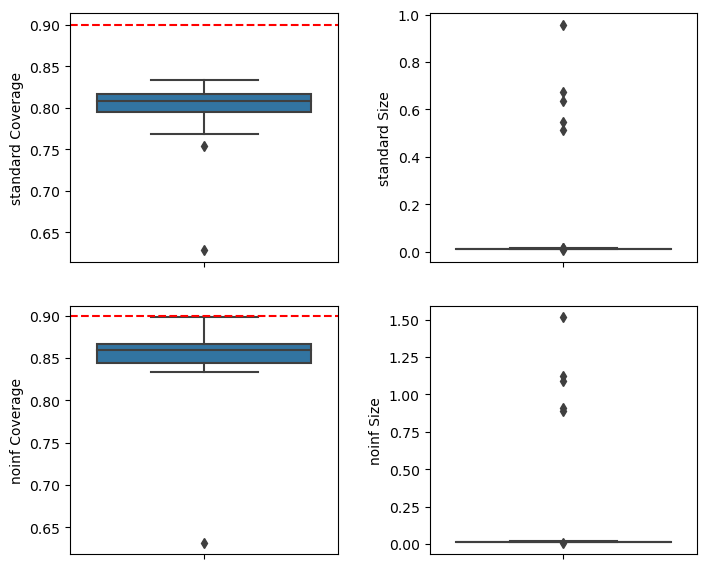

In [18]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results_ws['Calib_size'].iloc[0], 
              results_ws['Train_size'].iloc[0], results_ws['Theory_size'].iloc[0]))

fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout(w_pad=3.5)
sns.boxplot(y="standardCoverage", data=results_ws, ax=axs[0,0])
axs[0,0].set(ylabel='standard Coverage')
axs[0,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="standardSize", data=results_ws, ax=axs[0,1])
axs[0,1].set(ylabel='standard Size')

sns.boxplot(y="noinfCoverage", data=results_ws, ax=axs[1,0])
axs[1,0].set(ylabel='noinf Coverage')
axs[1,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="noinfSize", data=results_ws, ax=axs[1,1])
axs[1,1].set(ylabel='noinf Size')
plt.show()

In [19]:
results_ws

,standardCoverage,standardSize,infCoverage,infSize,noinfCoverage,noinfSize,inf_prop,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Test_size,Theory_size
0,0.628148,0.015438,0.631667,0.015854,0.631667,0.015854,0.0,0.076343,7.024646e-06,1.201699,0.1,0,3600,14400,5400,71214.0
0,0.801490,0.011440,0.833015,0.012615,0.833015,0.012615,0.0,0.000013,4.493116e-06,0.000024,0.1,1,3600,14400,5234,71214.0
0,0.804982,0.010987,0.841089,0.012387,0.841089,0.012387,0.0,0.000012,4.030408e-06,0.000023,0.1,2,3600,14400,5179,71214.0
0,0.767702,0.545064,0.859523,0.911050,0.859523,0.911050,0.0,16.554211,2.007587e-02,150.702055,0.1,3,3600,14400,5282,71214.0
0,0.779936,0.957446,0.863067,1.516234,0.863067,1.516234,0.0,5.714386,4.354579e-02,65.758560,0.1,4,3600,14400,5353,71214.0
0,0.783740,0.673397,0.859117,1.091699,0.859117,1.091699,0.0,11.591975,3.010847e-02,204.841849,0.1,5,3600,14400,5572,71214.0
0,0.788901,0.014815,0.849926,0.017921,0.849926,0.017921,0.0,0.000021,6.753511e-06,0.000051,0.1,6,3600,14400,5424,71214.0
0,0.824004,0.012295,0.866344,0.014391,0.866344,0.014391,0.0,0.000015,4.709815e-06,0.000026,0.1,7,3600,14400,5574,71214.0
0,0.788956,0.010950,0.835429,0.012477,0.835429,0.012477,0.0,0.000012,4.243920e-06,0.000023,0.1,8,3600,14400,5487,71214.0
0,0.822858,0.012396,0.839884,0.012954,0.839884,0.012954,0.0,0.000016,5.050918e-06,0.000027,0.1,9,3600,14400,5521,71214.0


In [20]:
results_marginal

,marginalCoverage,marginalSize
0,0.728111,0.015438
0,0.889931,0.011440
0,0.899028,0.010987
0,0.899750,0.545064
0,0.903194,0.957446
0,0.899917,0.673397
0,0.910681,0.014815
0,0.905722,0.012295
0,0.892028,0.010950
0,0.896153,0.012396
